In [1]:
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import torch

# 从零实现版本

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 X∈R1000×2X∈R 
1000×2
 ，我们使用线性回归模型真实权重 w=[2,−3.4]⊤w=[2,−3.4] 
⊤
  和偏差 b=4.2b=4.2，以及一个随机噪声项 ϵϵ 来生成标签

y=Xw+b+ϵ

In [2]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])  # 1 * 2
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)  # 1000 * 2
labels = torch.matmul(features, true_w) + true_b
epson = torch.tensor(np.random.normal(
    0, 0.01, size=labels.size()), dtype=torch.float32)
labels += epson

In [3]:
labels

tensor([ 3.2067e+00, -7.6520e-01,  5.8324e+00,  3.0339e+00,  5.2292e+00,
         2.5063e+00,  3.9572e+00,  4.4305e+00,  9.4675e+00,  1.0655e+01,
         1.2820e-01,  4.2018e+00,  3.2774e+00,  3.6041e+00,  4.4263e+00,
         4.5670e+00,  6.9615e+00,  7.7648e+00,  9.9581e-01,  7.2829e+00,
         7.3469e+00,  6.3633e+00,  4.4244e+00,  3.4554e-01,  3.3501e+00,
         6.1150e+00,  2.8571e+00,  4.0579e+00,  1.2784e+00,  1.5686e+00,
         2.5846e+00,  6.0434e+00, -3.0056e+00,  8.0666e+00,  4.1805e+00,
         2.4151e+00,  7.6850e+00,  7.9455e+00,  8.2825e+00,  7.2812e+00,
         3.7899e+00,  4.9913e+00,  7.1592e+00,  1.4271e+00,  8.1234e+00,
        -6.8289e-01,  3.2466e+00,  5.2215e-01,  6.1762e-01,  7.7235e-01,
         5.9019e+00,  1.8907e+00, -4.0403e+00,  3.4681e+00, -8.7394e-01,
         1.5625e+01, -5.6281e+00,  7.0310e+00,  9.0553e-01,  8.0976e+00,
         6.5669e+00,  6.6174e+00,  3.2067e+00, -6.0058e-01,  3.9177e+00,
         5.3403e+00,  4.5283e+00,  5.9134e+00,  7.4

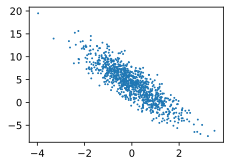

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import *


set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

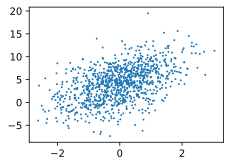

In [5]:
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1)

## 读取数据

In [6]:
def data_iter(batch_size, features, labels):
    '''
    按照批次读取数据
    '''
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(
            indices[i: min(i + batch_size, num_examples)])  # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[-0.4000, -0.7227],
        [-0.4473, -0.3004],
        [ 0.1451,  1.3192],
        [ 2.1649,  0.3321],
        [ 1.5703,  0.3588],
        [ 0.4929, -1.5272],
        [ 0.0441, -0.1350],
        [-0.3308, -0.6496],
        [ 0.1736,  1.2334],
        [ 0.4386,  0.4989]])
tensor([5.8506e+00, 4.3515e+00, 8.3223e-03, 7.4248e+00, 6.1326e+00, 1.0372e+01,
        4.7478e+00, 5.7479e+00, 3.3430e-01, 3.3892e+00])


## 初始化参数

In [7]:
w = torch.tensor(np.random.normal(
    0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# w 和 b需要求导
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 定义模型

In [8]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

## 定义损失函数

In [9]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 定义优化算法

In [10]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size  # 注意这里更改param时用的param.data

## 训练模型

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.045630
epoch 2, loss 0.000186
epoch 3, loss 0.000050


In [12]:
print(true_w, '\n', w)
print(true_b, '\n', b)

tensor([ 2.0000, -3.4000]) 
 tensor([[ 2.0000],
        [-3.3995]], requires_grad=True)
4.2 
 tensor([4.1999], requires_grad=True)


# 线性回归简洁方式实现
## 生成数据集

In [13]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])  # 1 * 2
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)  # 1000 * 2
labels = torch.matmul(features, true_w) + true_b
epson = torch.tensor(np.random.normal(
    0, 0.01, size=labels.size()), dtype=torch.float32)
labels += epson

## 读取数据

In [14]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [15]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[ 8.4943e-01,  1.9444e+00],
        [ 1.4162e+00, -2.2318e-01],
        [-2.7780e-01,  9.4792e-01],
        [ 5.4615e-01, -1.0519e+00],
        [ 1.7415e+00,  9.2010e-02],
        [-7.6161e-03, -7.2746e-04],
        [ 1.2422e+00, -1.1388e+00],
        [ 1.2406e+00, -1.6397e+00],
        [-2.0038e+00,  9.2997e-01],
        [-1.9833e+00, -3.4603e-01]]) tensor([-0.7018,  7.7810,  0.4044,  8.8726,  7.3671,  4.1910, 10.5528, 12.2512,
        -2.9631,  1.4088])


## 定义模型
### 方法1
- 继承Module类
- 定义前向传播forward

In [16]:
from torch import nn


class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播

    def forward(self, x):
        y = self.linear(x)
        return y


net = LinearNet(num_inputs)
print(net)  # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


### 法2

In [17]:
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [18]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6598, -0.2513]], requires_grad=True)
Parameter containing:
tensor([0.0054], requires_grad=True)


## 初始化参数

In [19]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

## 定义损失函数

In [20]:
loss = nn.MSELoss()

## 定义优化算法

In [21]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 训练模型

In [22]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()  # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000188
epoch 2, loss: 0.000135
epoch 3, loss: 0.000066


In [23]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

tensor([ 2.0000, -3.4000]) Parameter containing:
tensor([[ 2.0007, -3.3991]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2008], requires_grad=True)
